In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sentimentanalyser.utils.data  import Path, pad_collate, grandparent_splitter
from sentimentanalyser.utils.data  import parent_labeler, listify
from sentimentanalyser.data.text   import TextList, ItemList, SplitData
from sentimentanalyser.utils.files import pickle_dump, pickle_load

from sentimentanalyser.preprocessing.processor import TokenizerProcessor, NuemericalizeProcessor
from sentimentanalyser.preprocessing.processor import CategoryProcessor

In [3]:
from functools import partial

In [4]:
path_imdb = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/imdb")

In [5]:
proc_tok = TokenizerProcessor()
proc_num = NuemericalizeProcessor()
proc_cat = CategoryProcessor()

In [6]:
tl_imdb = TextList.from_files(path=path_imdb, folders=['train','test'])
sd_imdb = tl_imdb.split_by_func(partial(grandparent_splitter, valid_name='test'))
ll_imdb = sd_imdb.label_by_func(parent_labeler, proc_x=[proc_tok, proc_num], proc_y=proc_cat)

In [7]:
imdb_data = ll_imdb.clas_databunchify(64)

# Using pre-trained embeddings

In [8]:
import torch
import torchtext
from torchtext import vocab
from sentimentanalyser.utils.preprocessing import default_spec_tok

In [9]:
path_cache = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Models/WordEmbeddings')

In [10]:
ft_eng = vocab.FastText(cache=path_cache)

In [11]:
glove_eng = vocab.GloVe(cache=path_cache)

In [12]:
from sentimentanalyser.utils.callbacks import sched_cos, combine_scheds
from sentimentanalyser.callbacks.training import LR_Find, CudaCallback, GradientClipping
from sentimentanalyser.callbacks.progress import ProgressCallback
from sentimentanalyser.callbacks.scheduler import ParamScheduler
from sentimentanalyser.callbacks.stats import AvgStatsCallback
from sentimentanalyser.callbacks.recorder import Recorder
from sentimentanalyser.training.trainer import Trainer

In [14]:
from sentimentanalyser.utils.dev import print_dims
from sentimentanalyser.utils.models import get_lens_and_masks
from sentimentanalyser.utils.metrics import accuracy
from tqdm.auto import tqdm

In [15]:
import torch
import torchtext
from torch import nn
from torchtext import vocab

import torch.nn.functional as F

#### Some helper functions and variables

In [16]:
x1,y1 = next(iter(imdb_data.train_dl))

## Transfer vocab

In [17]:
def get_embedding_vectors(local_vocab, torchtext_vocab):
    size, dims = torchtext_vocab.vectors.shape
    vector_values = []
    for tok in local_vocab:
        if tok in torchtext_vocab.stoi:
            vector_values.append(torchtext_vocab.vectors[
                                 torchtext_vocab.stoi[tok]].unsqueeze(0))
        else:
            vector_values.append(torch.zeros(1, dims))
    assert len(local_vocab) == len(vector_values)
    return torch.cat(vector_values, dim=0)

## LSTM Model with pre-trained embeddings

In [18]:
class WordSentenceAttn(nn.Module):
    def __init__(self, hidden_sz):
        super().__init__()
        
        self.context_weight     = nn.Parameter(torch.Tensor(hidden_sz).uniform_(-0.1,0.1))
        self.context_projection = nn.Linear(hidden_sz, hidden_sz)
    
    def forward(self, context):
        context_proj = torch.tanh(self.context_projection(context))
        αt = context_proj.matmul(self.context_weight)
        attn_score = F.softmax(αt, dim=1).unsqueeze(2)
        sentence = context.transpose(1,2).bmm(attn_score)
        return sentence.squeeze(2)

In [78]:
class PTLSTMModel(nn.Module):
    def __init__(self, hidden_sz=256, output_sz=2, dropout=0.5,
                 pad_idx=1, num_layers=2, bidirectional=True):
        super().__init__()
        
        self.pad_idx = pad_idx
        self.bidir   = 2 if bidirectional else 1
        embd_vecs = get_embedding_vectors(proc_num.vocab, ft_eng)
        self.embedding = nn.Embedding.from_pretrained(embd_vecs,
            freeze=False, padding_idx=pad_idx)
        
        self.dropout = nn.Dropout(dropout)
        
        self.rnn     = nn.LSTM(embd_vecs.shape[1], hidden_sz,
                               batch_first=True,
                               dropout=dropout,
                               num_layers=num_layers,
                               bidirectional=bidirectional)
        
        self.attn = WordSentenceAttn(self.bidir*hidden_sz)
        self.linear = nn.Linear(self.bidir*hidden_sz, output_sz)
    
    def forward(self, xb):
        seq_lens, mask = get_lens_and_masks(xb, self.pad_idx)
        
        embeded = self.dropout(self.embedding(xb))
        packed_emb = nn.utils.rnn.pack_padded_sequence(embeded, seq_lens,
                                                       batch_first=True)
        
        packed_out, (hidden_st, cell_st) = self.rnn(packed_emb)
        
        context, _ = nn.utils.rnn.pad_packed_sequence(packed_out,
                                                      batch_first=True)
        
        sentence = self.attn(context)
        return self.linear(sentence)

### Glove Concat Model

In [79]:
class GloveConcatModel(nn.Module):
    def __init__(self,local_vocab, torchtext_vocab, 
                 hidden_sz=256, output_sz=2, dropout=0.5,
                 num_layers=2, pad_idx=1, bidirectional=True):
        super().__init__()
        
        self.bidir   = 2 if bidirectional else 1
        self.pad_idx = pad_idx 
        
        embd_vecs = get_embedding_vectors(local_vocab, torchtext_vocab)
        self.embedding = nn.Embedding.from_pretrained(embd_vecs,
                                                      freeze= False,
                                                      padding_idx = pad_idx)
        
        self.dropout = nn.Dropout(dropout)
        
        self.rnn     = nn.LSTM(embd_vecs.shape[1], hidden_sz,
                               batch_first=True,
                               dropout=dropout,
                               num_layers=num_layers,
                               bidirectional=bidirectional)
        
        self.linear  = nn.Linear((2+num_layers)*hidden_sz*self.bidir,
                                 output_sz)
    
    def forward(self, xb):
        seq_lens, mask = get_lens_and_masks(xb, self.pad_idx)
        
        embedded = self.dropout(self.embedding(xb))
        packed   = nn.utils.rnn.pack_padded_sequence(embedded, seq_lens,
                                                     batch_first=True)
        
        packed_out, (hidden_st, cell_st) = self.rnn(packed)
        
        lstm_out, lens = nn.utils.rnn.pad_packed_sequence(packed_out)
        
        avg_pool = F.adaptive_avg_pool1d(lstm_out.permute((1,2,0)), 1).squeeze()
        max_pool = F.adaptive_max_pool1d(lstm_out.permute((1,2,0)), 1).squeeze()
        
        hidden_st = hidden_st.view(hidden_st.shape[1], -1)
        
        combined = torch.cat([max_pool, avg_pool, hidden_st], dim=1)
        return self.linear(combined)

### Testing

In [80]:
model = GloveConcatModel(proc_num.vocab, glove_eng, num_layers=3)

In [81]:
%timeit y = model(x1)

7.12 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Training

In [41]:
def get_params(model):
    emb, wgts, biases = [],[],[]
    for name, param in model.named_parameters():
        if ('embedding' in name.split('.')):
            emb.append(param)
        elif ('weight' in name.split('.')):
            wgts.append(param)
        elif ('bias' in name.split('.')):
            biases.append(param)
    return emb, wgts, biases

In [42]:
def pg_dicts(pgs):
    return [{'params': p} for p in pgs]

In [45]:
def get_basic(Model, num_layers=1, disc_train=False):
    model = Model(proc_num.vocab, glove_eng,num_layers=num_layers)
    loss_func = nn.CrossEntropyLoss()
    if disc_train:
        pgs = pg_dicts(get_params(model))
        opt = torch.optim.Adam(pgs, lr=1e-3)
    else:
        opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
    return model, loss_func, opt

In [46]:
finder = Trainer(imdb_data,*get_basic(GloveConcatModel, num_layers=2),
                 cb_funcs=[LR_Find,Recorder,CudaCallback])

In [47]:
finder.fit()

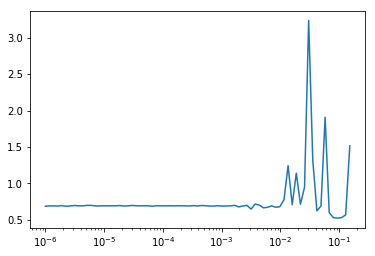

In [48]:
finder.recorder.plot(skip_last=1)

In [49]:
sched = combine_scheds([0.3, 0.7], [sched_cos(1e-4, 3e-3), sched_cos(3e-3, 3e-5)])

In [50]:
sched_emb = combine_scheds([0.3, 0.7], [sched_cos(3e-5, 5e-4), sched_cos(5e-4, 3e-5)])
sched_wgts = combine_scheds([0.3, 0.7], [sched_cos(3e-4, 1e-3), sched_cos(1e-3, 3e-5)])
sched_biases = combine_scheds([0.3, 0.7], [sched_cos(3e-3, 1e-2), sched_cos(1e-2, 3e-4)])

In [51]:
trainer = Trainer(imdb_data, *get_basic(GloveConcatModel, num_layers=2,
                                        disc_train=False),
    cb_funcs=[
    partial(AvgStatsCallback, [accuracy]),
    partial(ParamScheduler,'lr', [sched]),
    partial(GradientClipping, clip=0.1),
    ProgressCallback,
    CudaCallback,
    Recorder
])

In [52]:
trainer.fit()

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.440455,0.774560,0.251396,0.901520,01:39
1,0.220803,0.914960,0.236589,0.906240,01:40
2,0.080286,0.974080,0.328166,0.899000,01:40


In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.recorder.lrs[0])
plt.plot(trainer.recorder.lrs[1])
plt.plot(trainer.recorder.lrs[2])
plt.legend(['emb','wgts','biases']);